    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed ForwardDiff ─ v0.10.20
    Updating `~/.julia/dev/AD_GS/Project.toml`
  [f6369f11] + ForwardDiff v0.10.20
    Updating `~/.julia/dev/AD_GS/Manifest.toml`
  [f6369f11] ↑ ForwardDiff v0.10.19 ⇒ v0.10.20
Precompiling project...
  ✓ ForwardDiff
  ✓ NLSolversBase
  ✓ LineSearches
  ✓ Optim
  ✓ JuMP
  ✓ Equilibrium
  ✓ LazySets
  ✗ AD_GS
7 dependencies successfully precompiled in 23 seconds (171 already precompiled)
1 dependency errored


In [2]:
using Revise
using AD_GS
import Equilibrium
using Plots
using Optim
using LinearAlgebra

symmetric=true
diverted=true
δ = 0.7
ϵ = 0.32
κ = 1.9
B0 = 2.0
R0 = 1.8
qstar = 1.57
alpha = -0.155

symmetric=true
diverted=true
δ = -0.7
ϵ = 0.32
κ = 1.9
B0 = 2.0
R0 = 1.7
qstar = 1.57
alpha = -0.155

# symmetric=true
# diverted=true
# δ = -0.0
# ϵ = 0.32
# κ = 2.1
# B0 = 2.0
# R0 = 1.7
# qstar = 1.57
# alpha = -0.155

# symmetric=true
# diverted=false
# δ = -0.0
# ϵ = 0.32
# κ = 1.0
# B0 = 2.0
# R0 = 1.7
# qstar = 1.57
# alpha = .9

symmetric=true

S = Equilibrium.solovev(B0, R0, ϵ, δ, κ, alpha, qstar, B0_dir=1,Ip_dir=1,diverted=diverted,symmetric=symmetric)
S0 = Equilibrium.solovev(B0, R0, ϵ, δ, κ, alpha, qstar,B0_dir=1,Ip_dir=1,diverted=false,symmetric=true)

dx=0.3
xlim, ylim = Equilibrium.limits(S)
xlim=(minimum(xlim)-dx,maximum(xlim)+dx)
ylim=(minimum(ylim)-dx,maximum(ylim)+dx);

S

SolovevEquilibrium
  B0 = 2.0 [T]
  R0 = 1.7 [m]
  ϵ  = 0.32
  δ  = -0.7
  κ  = 1.9
  α  = -0.155
  q⋆ = 1.57
  βp = 0.8434490944513139
  βt = 0.035039631332636025
  σ  = 1
  diverted  = true
  symmetric = true

In [17]:
using StaticArrays
using PolygonOps
using Interpolations
using Contour

resolution=33
r = range(xlim[1]-dx,xlim[2]+dx,length=resolution)
z = range(ylim[1]-dx,ylim[2]+dx,length=resolution*Int(round((ylim[2]-ylim[1]/(xlim[2]-xlim[1])))))
pts = [((kr,kz),(rr,zz)) for (kz,zz) in enumerate(z), (kr,rr) in enumerate(r)]

dst = zeros(size(pts)...).+1

# domain
pr_outer=[xlim[1],xlim[2],xlim[2],xlim[1],xlim[1]]
pz_outer=[ylim[2],ylim[2],ylim[1],ylim[1],ylim[2]]
for ((kr,kz),(rr,zz)) in hcat(pts...)
    point = SA[rr,zz]
    if PolygonOps.inpolygon((rr,zz), StaticArrays.SVector.(pr_outer, pz_outer)) == 1
        dst[kz,kr] = 0
    end
end

# plasma distance
ψ0, ψb = Equilibrium.psi_limits(S0)
Psi0 = [S0(rr,zz) for (kz,zz) in enumerate(z), (kr,rr) in enumerate(r)]
Psi=Psi0.-dst*1E1
#display(Plots.contour(r,z,Psi,levels=[(ψb-ψ0)*level+ψ0],xlim=[r[1],r[end]],ylim=[z[1],z[end]], aspect_ratio=:equal))
level=1.35
cl = Contour.contour(z,r,Psi,(ψb-ψ0)*level+ψ0)
pr_inner=nothing
pz_inner=nothing
for line in Contour.lines(cl)
    pz_inner, pr_inner = Contour.coordinates(line)
    # ignore flux surfaces that do not close
    if !((pr_inner[1] == pr_inner[end]) & (pz_inner[1] == pz_inner[end]))
        continue
    end
    # only consider flux surfaces that contain magnetic axis
    if PolygonOps.inpolygon(((xlim[2]+xlim[1])/2,(ylim[2]+ylim[1])/2), StaticArrays.SVector.(pr_inner, pz_inner)) == 1
        break
    end
end

for ((kr,kz),(rr,zz)) in hcat(pts...)
    point = SA[rr,zz]
    if PolygonOps.inpolygon((rr,zz), StaticArrays.SVector.(pr_inner, pz_inner)) == 1
        dst[kz,kr] = 1
    end
end

#display(heatmap(r,z,dst,xlim=[r[1],r[end]],ylim=[z[1],z[end]], aspect_ratio=:equal))
dst_interpolant = Interpolations.extrapolate(Interpolations.interpolate((z, r), dst, Interpolations.Gridded(Interpolations.Linear())),Interpolations.Flat());

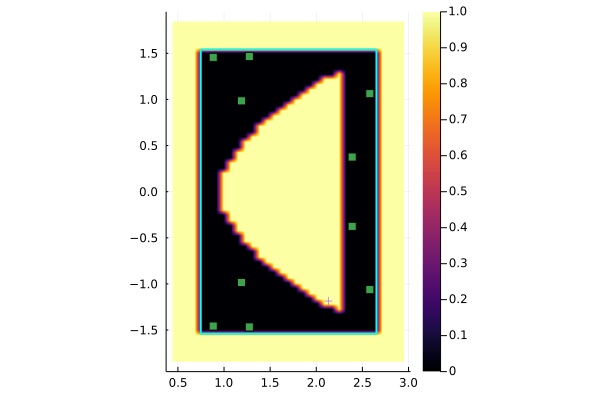

In [26]:
dxx=0.01
r = range(xlim[1]-dx,xlim[2]+dx,step=dxx)
z = range(ylim[1]-dx,ylim[2]+dx,step=dxx)
dst=dst_interpolant(z,r)
heatmap(r,z,dst,xlim=[r[1],r[end]],ylim=[z[1],z[end]], aspect_ratio=:equal)
#plot!(pr_inner,pz_inner,lw=2,color=:magenta,label="")
plot!(pr_outer,pz_outer,lw=2,color=:cyan,label="")


using Random

ncoils = 10
coils=[]
discarded_coils = []
while length(coils)<ncoils
    rp=rand()*(xlim[2]-xlim[1])+xlim[1]
    zp=rand()*(ylim[2]-ylim[1])+ylim[1]
    if dst_interpolant.(zp,rp)==0
        if symmetric
            push!(coils,(rp,abs(zp)))
            push!(coils,(rp,-abs(zp)))
        else
            push!(coils,(rp,zp))
        end
    else
        push!(discarded_coils,(rp,zp))
    end
end

#coils=coils_D3D_points;

λ_regularize0 = 1E-13

function pack(coils, λ_regularize)
    coilz = vcat([c[1] for c in coils if ((! symmetric) || c[2]>0)],[c[2] for c in coils if ((! symmetric) || c[2]>0)])
    packed = vcat(coilz, λ_regularize)
    return packed
end
function unpack(packed)
    coilz = packed[1:end-1]
    λ_regularize = abs(packed[end])
    coils =  [(coilz[k],coilz[k+Int(length(coilz)/2)]) for (k,c) in enumerate(coilz[1:Int(end/2)])]
    if symmetric
        coils = vcat(coils,[(c[1],-c[2]) for c in coils])
    end
    return coils, λ_regularize
end

packed = pack(coils, λ_regularize0)
(coils, λ_regularize) = unpack(packed)
coils0 = coils

plot!([c[1] for c in coils],[c[2] for c in coils],markershape=:rect,lw=0,label="")
display(plot!([c[1] for c in discarded_coils],[c[2] for c in discarded_coils],markershape=:cross,lw=0,label="",xlim=[r[1],r[end]],ylim=[z[1],z[end]], aspect_ratio=:equal))

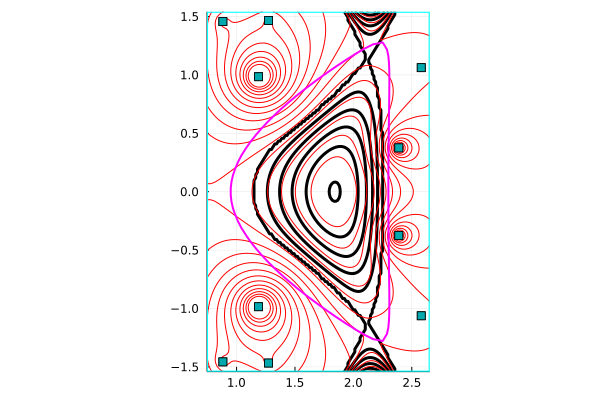

  0.037210 seconds (15.14 k allocations: 5.059 MiB)
 * Status: success

 * Candidate solution
    Final objective value:     1.037847e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit 30)
    Iterations:    6277
    f(x) calls:    9906


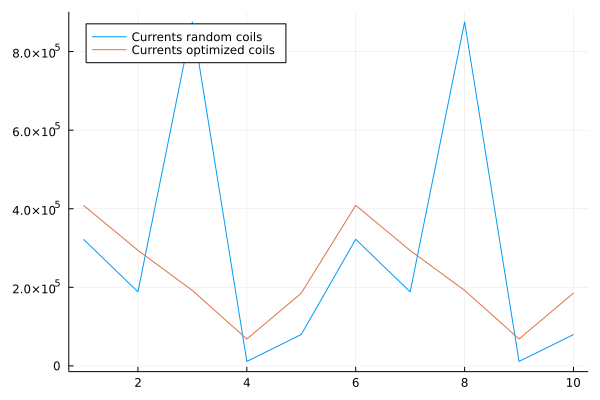

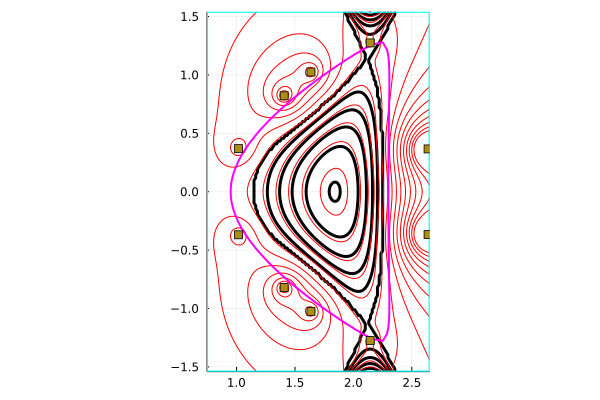

 * Status: failure (line search failed)

 * Candidate solution
    Final objective value:     1.028608e+00

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.04e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.94e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.24e-03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.98e-03 ≰ 0.0e+00
    |g(x)|                 = 1.93e+10 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit 30)
    Iterations:    5
    f(x) calls:    274
    ∇f(x) calls:   274
    ∇²f(x) calls:  5
  0.037064 seconds (15.13 k allocations: 5.048 MiB)
λ_regularize = 2.1955943481154908e-14


In [35]:
coils = coils0
λ_regularize = λ_regularize0

@time currents0,cost0 = fixed_eq_currents(S,coils0,λ_regularize=λ_regularize,λ_minimize=0.0, λ_zerosum=0.0, return_cost=true)
check_fixed_eq_currents(S,coils0,currents0,resolution=129, Rmin=xlim[1], Rmax=xlim[2], Zmin=ylim[1], Zmax=ylim[2])
plot!([c[1] for c in coils0],[c[2] for c in coils0],markershape=:rect,lw=0,label="")
plot!(pr_inner, pz_inner, lw=2, color=:magenta,label="")
plot!(pr_outer, pz_outer, lw=2, color=:cyan,label="")
display(plot!([c[1] for c in coils0],[c[2] for c in coils0],markershape=:rect,lw=0,label=""))

function optimize_coils(S, coils, λ_regularize, ψp_cost_norm, currents_cost_norm, mask_interpolant)
    fixed_eq = ψp_on_fixed_eq_boundary(S)
    packed = pack(coils, λ_regularize)
    
    function placement_cost(packed)
        (coils, λ_regularize) = unpack(packed)
        currents, cost = currents_to_match_ψp(fixed_eq...,coils, λ_regularize=λ_regularize, λ_minimize=0.0, λ_zerosum=0.0, return_cost=true)
        cost = cost/ψp_cost_norm
        cost += norm(currents)/currents_cost_norm
        cost += norm(mask_interpolant.([c[2] for c in coils],[c[1] for c in coils]))*10
        return cost
    end

    # other optimizer that works is Newton(), others have trouble
    res = Optim.optimize(placement_cost, packed, Optim.NelderMead(), Optim.Options(time_limit=30,iterations=10000); autodiff=:forward)
    packed = Optim.minimizer(res)
    (coils, λ_regularize) = unpack(packed)
    print(res)
    
    if true
        res = Optim.optimize(placement_cost, packed, Optim.Newton(), Optim.Options(time_limit=30,iterations=10000); autodiff=:forward)
        packed = Optim.minimizer(res)
        (coils, λ_regularize) = unpack(packed)
        print(res)
    end

    return coils, λ_regularize
end

(coils, λ_regularize) = optimize_coils(S, coils, λ_regularize, cost0, 1E6, dst_interpolant)

plot(abs.(currents0),label="Currents random coils", legend=:topleft)
@time currents = fixed_eq_currents(S, coils, λ_regularize=λ_regularize, λ_minimize=0.0, λ_zerosum=0.0, verbose=true)
display(plot!(abs.(currents),label="Currents optimized coils", legend=:topleft))

check_fixed_eq_currents(S,coils,currents,resolution=129, Rmin=xlim[1], Rmax=xlim[2], Zmin=ylim[1], Zmax=ylim[2])
plot!(pr_inner, pz_inner, lw=2, color=:magenta,label="")
plot!(pr_outer, pz_outer, lw=2, color=:cyan,label="")
display(plot!([c[1] for c in coils],[c[2] for c in coils],markershape=:rect,lw=0,label=""))

@show(λ_regularize);